### 문서 스캐너

- 카메라로 촬영한 문서 영상을 똑바로 펴서 저장해주는 프로그램

- 구현할 기능

   - 마우스로 문서 모서리 선택 & 이동
   
   - 키보드 ENTER키 인식
   
   - 왜곡된 문서 영상을 직사각형 형태로 똑바로 펴기(투시 변환)
   
   
- 마우스로 문서 모서리 선택 및 이동하기


   - 마우스 왼쪽 버튼이 눌린 좌표가 네 개의ㅣ 모서리와 근접인지 검사
   
   - 특정 모서리 선택했다면 마우스 드래그 검사
   
   - 마우스 드래그 시 좌표 이동 및 화면 표시
   
   - 마우스 왼쪽 버튼이 떼어졌을 시 좌표를 기록
   
 - 투시 변환(왜곡된 문서 펴기)
 
    - 네 개의 모서리 좌표를 순서대로 srcQuad배열에 추가
    
    - dstQuad 배열에는 미리 정의한 A4 용지 크기의 네 모서리 좌표 저장
    
    - srcQuad 점들로부터 dstQuad점들로 이동하는 투시 변환 계산
    
    - 계산된 투시 변환 행렬을 이용하여 영상을 투시 변환하여 화면 출력
 

### 예제

In [ ]:
import sys
import numpy as np
import cv2


def drawROI(img, corners):
    cpy = img.copy()

    c1 = (192, 192, 255)
    c2 = (128, 128, 255)

    for pt in corners:
        cv2.circle(cpy, tuple(pt.astype(int)), 25, c1, -1, cv2.LINE_AA)

    cv2.line(cpy, tuple(corners[0].astype(int)), tuple(corners[1].astype(int)), c2, 2, cv2.LINE_AA)
    cv2.line(cpy, tuple(corners[1].astype(int)), tuple(corners[2].astype(int)), c2, 2, cv2.LINE_AA)
    cv2.line(cpy, tuple(corners[2].astype(int)), tuple(corners[3].astype(int)), c2, 2, cv2.LINE_AA)
    cv2.line(cpy, tuple(corners[3].astype(int)), tuple(corners[0].astype(int)), c2, 2, cv2.LINE_AA)

    disp = cv2.addWeighted(img, 0.3, cpy, 0.7, 0)

    return disp


def onMouse(event, x, y, flags, param):
    global srcQuad, dragSrc, ptOld, src

    if event == cv2.EVENT_LBUTTONDOWN:
        for i in range(4):
            if cv2.norm(srcQuad[i] - (x, y)) < 25:
                dragSrc[i] = True
                ptOld = (x, y)
                break

    if event == cv2.EVENT_LBUTTONUP:
        for i in range(4):
            dragSrc[i] = False

    if event == cv2.EVENT_MOUSEMOVE:
        for i in range(4):
            if dragSrc[i]:
                dx = x - ptOld[0]
                dy = y - ptOld[1]

                srcQuad[i] += (dx, dy)

                cpy = drawROI(src, srcQuad)
                cv2.imshow('img', cpy)
                ptOld = (x, y)
                break


# 입력 이미지 불러오기
src = cv2.imread('scanned.jpg')

if src is None:
    print('Image open failed!')
    sys.exit()

# 입력 영상 크기 및 출력 영상 크기
h, w = src.shape[:2]
dw = 500
dh = round(dw * 297 / 210)  # A4 용지 크기: 210x297cm

# 모서리 점들의 좌표, 드래그 상태 여부
srcQuad = np.array([[30, 30], [30, h-30], [w-30, h-30], [w-30, 30]], np.float32)
dstQuad = np.array([[0, 0], [0, dh-1], [dw-1, dh-1], [dw-1, 0]], np.float32)
dragSrc = [False, False, False, False]

# 모서리점, 사각형 그리기
disp = drawROI(src, srcQuad)

cv2.imshow('img', disp)
cv2.setMouseCallback('img', onMouse)

while True:
    key = cv2.waitKey()
    if key == 13:  # ENTER 키
        break
    elif key == 27:  # ESC 키
        cv2.destroyWindow('img')
        sys.exit()

# 투시 변환
pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
dst = cv2.warpPerspective(src, pers, (dw, dh), flags=cv2.INTER_CUBIC)

# 결과 영상 출력
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


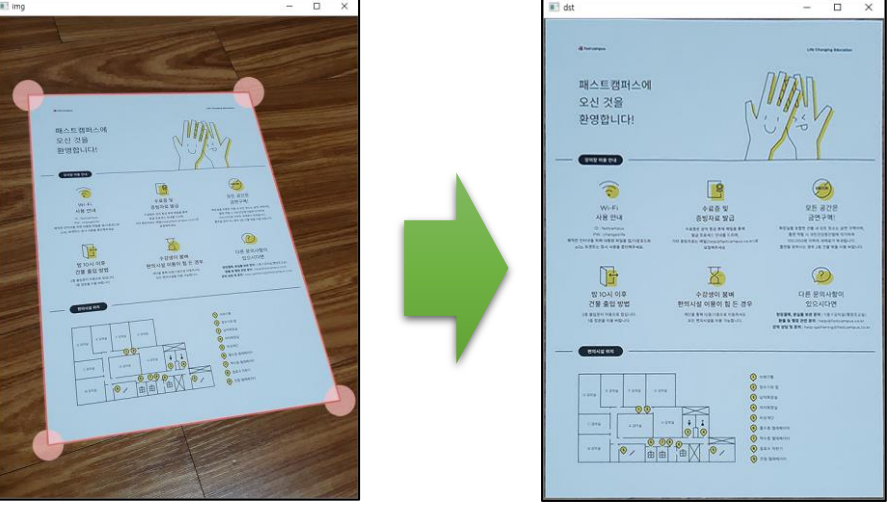